# Implementation

## Imports

In [2]:
import numpy as np
from scipy.linalg import orth
from scipy.linalg import svd
import matplotlib.pyplot as plt
import glob
import pandas as pd

from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

from time import time

## Functions

In [3]:
def compare_subject_score(Ctrue, C_est):
    plt.imshow(Ctrue)
    plt.colorbar()
    plt.title("True subject scores (C)")
    plt.show()

    plt.imshow(C_est)
    plt.colorbar()
    plt.title("Estimated subject scores (C_est)")
    plt.show()

In [4]:
def cross_val(model, X, y, K=10):
    kf = KFold(n_splits=10, shuffle=True)
    cvscores = cross_val_score(model, X, y, cv=kf)
    print("Scores:", cvscores.round(2))
    print("Accuracy: %0.2f (+/- %0.2f)" % (cvscores.mean(), cvscores.std() * 2))

In [5]:
def two_cross_val(model, alphas, X, y, errorf=accuracy_score, K1=10, K2=10, verbose=True):
    kf1 = KFold(n_splits=K1, shuffle=True)
    kf2 = KFold(n_splits=K2, shuffle=True)
    
    l1_acc = []
    for train_range, test_range in kf1.split(X):
        X_train, y_train = X[train_range], y[train_range]
        X_test, y_test = X[test_range], y[test_range]
        
        l2_acc = []
        for lambda_ in alphas:
            clfk = model(alpha=lambda_)
            scores = cross_val_score(clfk, X_train, y_train, cv=kf2)
            l2_acc.append((lambda_, scores.mean()))
        
        lambda_opt = max(l2_acc, key=lambda t:t[1])[0]
        clf_opt = model(alpha=lambda_opt)
        clf_opt.fit(X_train, y_train)
        l1_acc.append((lambda_opt, errorf(y_test, clf_opt.predict(X_test))))

    if verbose==True:
        if errorf==accuracy_score:
            print("Scores:", np.round(l1_acc, 2)[:, 1])
            print("Accuracy: %0.2f (+/- %0.2f)" % (np.mean(l1_acc, axis=0)[1], np.std(l1_acc, axis=0)[1] * 2))
        elif errorf == mean_squared_error:
            print("Scores:", np.round(l1_acc, 2)[:, 1])
            print("Mean squared error: %0.2f (+/- %0.2f)" % (np.mean(l1_acc, axis=0)[1], np.std(l1_acc, axis=0)[1] * 2))
    
    return l1_acc

## 1. Data

### 1.1 Actual data

In [7]:
def read_data(path, target_columns):
    targets = target_columns
    # Load files
    files = glob.glob(path + "*.txt")
    file0 = np.loadtxt(files[0])
    f_shape = file0.shape
    f_bytes = file0.nbytes
    N, M = f_shape[0] * len(files), f_shape[1]
    print("Files: {}\nFile shape: {}\nFile size: {} KB\nTotal: {}, {} MB".format(
            len(files), f_shape, f_bytes/1000, (N, M), (f_bytes*len(files))/1000000))
    
    print("Loading data...")
    
    # Load target data
    dfy = pd.read_csv("C:/Users/amont/Desktop/DTU/02460 Advanced Machine Learning/fMRI/Data/HCP1200_behavioural.csv")
    
    # Get list of subjects
    subs = [int(file.split("\\")[-1][:-4]) for file in files]
    
    # Get target variable columns
    targets.insert(0, "Subject")
    dfsg = dfy[targets][dfy["Subject"].isin(subs)].values
    np.random.shuffle(dfsg)
    
    if targets[1] == "Gender":
        y = np.array(list(map(lambda x: 0 if x=="M" else 1, dfsg[:,1])))
    elif targets[1] == "Age":
        y = label, yr = np.unique(targets[:,2], return_inverse=True)
    elif "NEOFAC" in targets[1]:
        dfsg = dfsg[~np.isnan(dfsg[:,1].astype(float))]
        y = dfsg[:,1]
              
    # Load X
    X = [np.loadtxt(files[i].split("\\")[0] + "\\" + str(int(dfsg[i, 0])) + ".txt") for i in range(dfsg.shape[0])]
    X = np.array(X)
    X = np.transpose(X)
    print("done")
    
    return X, y

### 1.2 Generate data

In [6]:
def generate_parafac2_data_grouping(p, T, S):

    X = np.zeros((p, T, S))    # Data matrix
    R = np.random.randn(p,p)   # R Matrix
    fscale = np.sqrt(np.sum(R**2))     # Normalize rows of R (Frobenius norm of a given row should be equal to 1)
    C = np.zeros((p, S))       # Subject specific scores in columns of C
    P = np.zeros((p, T, S))    # Orthonormal timeseries
    noise = 0.01
    
    # Grouping
    muC = 10*np.random.randn(p, 2)
    y = [np.ones((1, np.ceil(S/2).astype(int))), 2*np.ones((1, np.floor(S/2).astype(int)))]
    
    # For each subject in group 1
    for s in range(int(S/2)):
        C[:,s] = np.random.normal(muC[:,0], size=p)
        D = np.diag(C[:,s])
        P[:,:,s] = np.transpose(orth(np.transpose(np.random.randn(p,T))))
        X[:,:,s] = np.dot(np.dot(D*fscale, R*(1/fscale)),P[:,:,s]) + noise * np.random.randn(p,T)
        
    # For each subject in group 2
    for s in range(int(S/2), S):
        C[:,s] = np.random.normal(muC[:,1], size=p)
        D = np.diag(C[:,s])
        P[:,:,s] = np.transpose(orth(np.transpose(np.random.randn(p,T))))
        X[:,:,s] = np.dot(np.dot(D*fscale, R*(1/fscale)),P[:,:,s]) + noise * np.random.randn(p,T)
    
    return X, y, C

## 2. Models

### 2.1 Baseline1 (Covariance matrix)

In [7]:
class CovBaseline:
    
    def __init__(self):
        self.p, self.T, self.S = None, None, None
        self.cov = None
        self.PC = None
    
    def _PCA(self):
        U, S, Vt = svd(self.cov)
        self.PC = np.dot(self.cov, np.transpose(Vt))
        
    def fit(self, X):
        self.p, self.T, self.S = X.shape
        self.cov = np.zeros((self.S, int(self.p*(self.p+1)/2)))
        
        for s in range(self.S):
            indices = np.triu_indices(self.p)
            self.cov[s] = np.cov(X[:,:,s])[indices]
        
        self._PCA()

### 2.2 Baseline2 (Correlation matrix)

In [8]:
class CorrBaseline:
    
    def __init__(self):
        self.p, self.T, self.S = None, None, None
        self.corr = None
        
    def _PCA(self):
        U, S, Vt = svd(self.corr)
        self.PC = np.dot(self.corr, np.transpose(Vt))
        
    def fit(self, X):
        self.p, self.T, self.S = X.shape
        self.corr = np.zeros((self.S, int(self.p*(self.p-1)/2)))
        
        for s in range(self.S):
            indices = np.triu_indices(self.p, 1)
            self.corr[s] = np.corrcoef(X[:,:,s])[indices]
            
        self._PCA()    

### 2.3 PARAFAC2 (without noise parameter)
\begin{align*}
\text{I)} &\qquad \mathbf{P}^{new} = \mathbf{V}\mathbf{U}^{\top} = (\mathbf{U}\mathbf{V}^{\top})^{\top}\\
\text{II)} &\qquad \mathbf{D}^{(s)}_{ii} = \dfrac{(\mathbf{R}\mathbf{P}^{(s)}\mathbf{X}^{(s)\top})_{ii}}{(\mathbf{R}\mathbf{R}^{T})_{ii}}\\
\text{III)} &\qquad \mathbf{R}^{new} = \dfrac{\sum_{s}\mathbf{D}^{(s)\top}\mathbf{X}^{(s)}\mathbf{P}^{(s)\top}}{\sum_{s}\mathbf{D}^{(s)\top}\mathbf{D}^{(s)}}
\end{align*}
where
\begin{align*}
\mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top} = \text{SVD}(\mathbf{X}^{(s)\top}\mathbf{D}^{(s)}\mathbf{R})
\end{align*}
and
\begin{align*}
\mathbf{X} = \mathbf{D}\mathbf{R}\mathbf{P} + \mathbf{E}
\end{align*}
Loss function
\begin{align*}
\mathcal{L} &= \sum_{s=1}^{S}||\mathbf{X}^{(s)} - \mathbf{D}^{(s)}\mathbf{R}\mathbf{P}^{(s)}||^{2}_{F}\\
&= \sum_{s=1}^{S} tr\big[(\mathbf{X}^{(s)} - \mathbf{D}^{(s)}\mathbf{R}\mathbf{P}^{(s)})(\mathbf{X}^{(s)} - \mathbf{D}^{(s)}\mathbf{R}\mathbf{P}^{(s)})^{\top}\big]
\end{align*}

In [9]:
class PARAFAC2:
    
    def __init__(self):
        self.p, self.T, self.S = None, None, None
        self.R = None       # R Matrix
        self.C = None       # Subject specific scores in columns of C
        self.P = None
        
    def _loss(self, X):
        
        loss_ = 0
        for s in range(self.S):
            XDRP = X[:,:,s] - (np.c_[self.C[:,s]] * self.R).dot(self.P[:,:,s])
            tr = np.sum((XDRP * XDRP).sum(-1))
            loss_ += tr

        return loss_

    
    def _train_step(self, X):
        
        r_numerator = np.zeros((self.p,self.p))
        r_denominator = np.zeros((self.p))
        for s in range(self.S):
                  
            ## Update P
            U, Sig, Vt = svd(X[:,:,s].T.dot(np.c_[self.C[:,s]]*self.R), full_matrices=False)
            self.P[:,:,s] = U.dot(Vt).T



            ## Update C
            d_numerators = np.diag(self.R.dot(self.P[:,:,s]).dot(X[:,:,s].T))
            d_denominators = (self.R*self.R).sum(-1)
            self.C[:,s] = d_numerators / d_denominators

            # Constrain to non-negativity again after having updated C
            if self.C.sum() < 0:
                self.C = self.C*-1
                self.C[self.C < 0] = 0
                self.P = self.P*-1
            else:
                self.C[self.C < 0] = 0


            ## Update R
            r_numerator += self.P[:,:,s].dot((self.C[:,s]*X[:,:,s].T)).T
            r_denominator += self.C[:,s]*self.C[:,s]

        self.R = r_numerator / np.c_[r_denominator]
            
    def fit(self, X, n_epochs):
        self.p, self.T, self.S = X.shape
        self.R = np.random.randn(self.p, self.p)
        self.C = np.random.randn(self.p, self.S)
        self.P = np.random.randn(self.p, self.T, self.S)
        
        print("Init loss:", self._loss(X))
        errors = []
        epochs = n_epochs

        for i in range(epochs):
            self._train_step(X)
            error = self._loss(X)
            errors.append(error)
            print(i, error)

        plt.figure(figsize=(13,5))
        plt.plot(errors)
        plt.show()

### 2.4 PARAFAC2 (with noise parameter)
\begin{align*}
\text{I)} &\qquad \mathbf{P}^{new} = \mathbf{V}\mathbf{U}^{\top} = \big(\mathbf{U}\mathbf{V}^{\top}\big)^{\top}\\
\text{II)} &\qquad \mathbf{D}^{(s)}_{ii} = \dfrac{\big(\mathbf{R}\mathbf{P}^{(s)}\mathbf{X}^{(s)\top}\mathbf{Q}^{(s)\top}\mathbf{Q}^{(s)}\big)_{ii}}{\big(\mathbf{Q}^{(s)\top}\mathbf{Q}^{(s)}\mathbf{R}\mathbf{R}^{T}\big)_{ii}}\\
\text{III)} &\qquad \mathbf{R}^{new} = \dfrac{\sum_{s}\mathbf{D}^{(s)\top}\mathbf{Q}^{(s)\top}\mathbf{Q}^{(s)}\mathbf{X}^{(s)}\mathbf{P}^{(s)\top}}{\sum_{s}\mathbf{D}^{(s)\top}\mathbf{Q}^{(s)\top}\mathbf{Q}^{(s)}\mathbf{D}^{(s)}}\\
\text{IV)} &\qquad \mathbf{Q}^{new}_{(v,s)} = \sqrt{\dfrac{1}{\dfrac{1}{T}\sum_{t}\big(\mathbf{X}^{(s,v)}-\big(\mathbf{D}^{(s)}\mathbf{R}\mathbf{P}^{(s)}\big)^{(v)}\big)^{2}}}
\end{align*}
where
\begin{align*}
\mathbf{U}\mathbf{\Sigma}\mathbf{V}^{\top} = \text{SVD}\big(\mathbf{X}^{(s)\top}\mathbf{Q}^{(s)\top}\mathbf{Q}^{(s)}\mathbf{D}^{(s)}\mathbf{R}\big)
\end{align*}
and
\begin{align*}
\mathbf{X} = \mathbf{D}\mathbf{R}\mathbf{P} + \mathbf{E}
\end{align*}
Loss function
\begin{align*}
\mathcal{L} &= \sum_{s=1}^{S}\big|\big|diag\big(\dfrac{1}{\sigma^{2}_{s,v}}\big)\big(\mathbf{X}^{(s)} - \mathbf{D}^{(s)}\mathbf{R}\mathbf{P}^{(s)}\big)\big|\big|^{2}_{F}\\
&= \sum_{s=1}^{S} \dfrac{1}{2}\bigg(tr\bigg[\big(\mathbf{Q}^{(s)}\big(\mathbf{X}^{(s)} - \mathbf{D}^{(s)}\mathbf{R}\mathbf{P}^{(s)}\big)\big)\big(\mathbf{Q}^{(s)}\big(\mathbf{X}^{(s)} - \mathbf{D}^{(s)}\mathbf{R}\mathbf{P}^{(s)}\big)\big)^{\top}\bigg] - T \cdot \sum_{v} \log\big(2\pi \cdot Q^{(s,v)2}\big) \bigg)
\end{align*}

In [10]:
class PARAFAC2_N:
    
    def __init__(self, tol):
        self.p, self.T, self.S = None, None, None
        self.R = None       # R Matrix
        self.C = None       # Subject specific scores in columns of C
        self.P = None
        self.Q = None
        self.tol = tol
        
    def _loss(self, X):
        
        loss_ = 0
        for s in range(self.S):
            Qs = np.c_[self.Q[:,s]]
            Cs = np.c_[self.C[:,s]]
            QXDRP = Qs*(X[:,:,s] - (Cs*self.R).dot(self.P[:,:,s]))
            tr = np.sum((QXDRP * QXDRP).sum(-1))
            loss_ += 1/2 * (tr - self.T * np.sum(np.log(2*np.pi * Qs**2)))

        return loss_

    
    def _train_step(self, X):
        
        r_numerator = np.zeros((self.p, self.p))
        r_denominator = np.zeros(self.p)
        for s in range(self.S):
            Ds = np.diag(self.C[:,s])
            
            ## Update Q
            self.Q[:,s] = np.sqrt(1/(1/self.T*np.sum((X[:,:,s] - (Ds.dot(self.R).dot(self.P[:,:,s])))**2, axis=1)))
            
            QQt = np.diag(self.Q[:,s]*self.Q[:,s])
            
            ## Update P
            U, S, Vt = svd(X[:,:,s].T.dot(QQt).dot(Ds).dot(self.R), full_matrices=False)
            self.P[:,:,s] = U.dot(Vt).T

            ## Update C
            c_numerator = np.diag(self.R.dot(self.P[:,:,s]).dot(X[:,:,s].T).dot(QQt))
            c_denominator = np.diag(QQt.dot(self.R).dot(self.R.T))
            self.C[:,s] = c_numerator / c_denominator
            
            # Constrain to non-negativity again after having updated C
            if self.C.sum() < 0:
                self.C = self.C*-1
                self.C[self.C < 0] = 0
                self.P = self.P*-1
            else:
                self.C[self.C < 0] = 0
                
            ## Update R
            r_numerator += Ds.dot(QQt).dot(X[:,:,s]).dot(self.P[:,:,s].T)
            r_denominator += self.C[:,s]*self.Q[:,s]*self.Q[:,s]*self.C[:,s]
            
        self.R = r_numerator / np.c_[r_denominator]
        
            
    def fit(self, X, n_epochs):
        self.p, self.T, self.S = X.shape
        self.R = np.random.randn(self.p, self.p)
        self.C = np.random.randn(self.p, self.S)
        self.P = np.random.randn(self.p, self.T, self.S)
        self.Q = np.random.randn(self.p, self.S)
        
        print("Init loss:", self._loss(X))
        errors = []
        epochs = n_epochs

        for i in range(epochs):
            self._train_step(X)
            error = self._loss(X)
            errors.append(error)
            print(i, error)

        plt.figure(figsize=(13,5))
        plt.plot(errors)
        plt.show()

## 3. Modelling

### 3.1 Load data

In [20]:
#targets = ["AngAffect_Unadj", "AngHostil_Unadj", "AngAggr_Unadj", "FearAffect_Unadj", "FearSomat_Unadj",
#           "Sadness_Unadj", "LifeSatisf_Unadj", "MeanPurp_Unadj", "PosAffect_Unadj", "Friendship_Unadj",
#           "Loneliness_Unadj", "PercHostil_Unadj", "PercReject_Unadj", "EmotSupp_Unadj", "InstruSupp_Unadj",
#           "PercStress_Unadj", "SelfEff_Unadj", "NEOFAC_A", "NEOFAC_O", "NEOFAC_C", "NEOFAC_N", "NEOFAC_E"]
#target_variables = ["Gender", "Age", "NEOFAC_A", "NEOFAC_O", "NEOFAC_C", "NEOFAC_N", "NEOFAC_E"]
HCP1200_behavioural.csv
Xr, yr = read_data("C:/Users/amont/Desktop/DTU/02460 Advanced Machine Learning/fMRI/Data/HCP1200_behavioural.csv", ["NEOFAC_E"])

NameError: name 'HCP1200_behavioural' is not defined

In [12]:
X = Xr
y = yr

### 3.2 Training

#### 3.2.1 PARAFAC2 without noise parameter


Shapes of parameter estimates:
X shape: (15, 4800, 1001)


Training model:
Init loss: 261501163275.99814
0 143348080689.38504
1 72335127113.77856
2 29746551783.31752
3 14765073799.880045
4 12628175302.720905
5 12371628614.59879
6 12321023339.873577
7 12293581022.154598
8 12289548090.019762
9 12289470439.577133
10 12230712287.691587
11 12217798428.826557
12 12217747191.22019
13 12217747093.37948
14 12217747093.134787


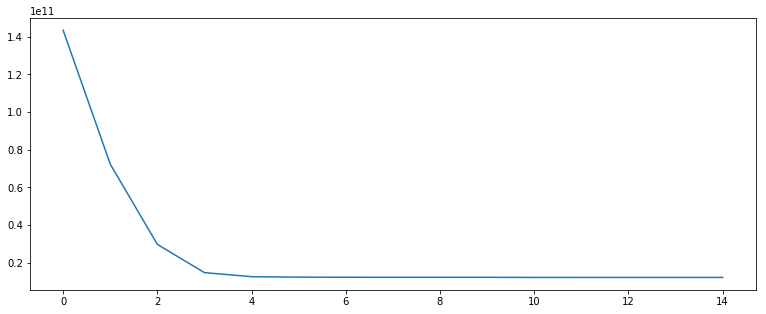

Training time: 230.23687s


In [13]:
# Initialize model
parafac2 = PARAFAC2()

print("\nShapes of parameter estimates:")
print("X shape:", X.shape)

# Train model
print("\n\nTraining model:")
start_time = time()
parafac2.fit(X, 15)
end_time = time()
print("Training time: {:.5f}s".format(end_time - start_time))
#compare_subject_score(Ctrue, parafac2.C)

#### 3.2.2 PARAFAC2 with noise parameter


Shapes of parameter estimates:
X shape: (15, 4800, 1001)


Training model:
Init loss: 129451602847.1635
0 256543131.41148844
1 256537318.9212645
2 256534525.417327
3 256532913.94545868
4 256532593.43701813
5 256532571.05424526
6 256532566.10604325
7 256532564.44755098
8 256532564.3597728
9 256532564.26390904
10 256532564.09876308
11 256532563.98570862
12 256532563.98426345
13 256532563.98425207
14 256532563.9842523


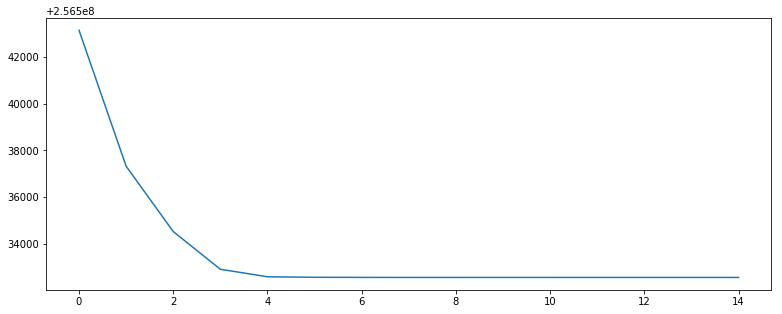

Training time: 235.47304s


In [14]:
# Initialize model
parafac2_n = PARAFAC2_N(tol=1e-4)

print("\nShapes of parameter estimates:")
print("X shape:", X.shape)

# Train model
print("\n\nTraining model:")
start_time = time()
parafac2_n.fit(X, 15)
end_time = time()
print("Training time: {:.5f}s".format(end_time - start_time))
#compare_subject_score(Ctrue, parafac2_n.C)

## 4. Group classification

### 4.1 Covariance baseline

In [15]:
cov_model = CovBaseline()
cov_model.fit(X)

#### 4.1.1 No PCA

In [16]:
#clf = RidgeClassifier
#errf = accuracy_score
clf = Ridge
errf = mean_squared_error

alphas = np.arange(0.1, 1.1, 0.1)
cv2 = two_cross_val(clf, alphas, cov_model.cov, y, errorf=errf, K1=10, K2=10)

Scores: [28.62 35.65 34.04 35.45 48.18 39.58 41.11 39.34 41.05 41.23]
Mean squared error: 38.42 (+/- 10.02)


#### 4.1.2 PCA

In [17]:
#clf = RidgeClassifier
#errf = accuracy_score
clf = Ridge
errf = mean_squared_error

alphas = np.arange(0.1, 1.1, 0.1)
cv2 = two_cross_val(clf, alphas, cov_model.PC, y, errorf=errf, K1=10, K2=10)

Scores: [37.61 37.99 42.99 48.1  34.59 35.79 36.53 36.45 36.86 37.12]
Mean squared error: 38.40 (+/- 7.71)


### 4.2 Correlation baseline

In [18]:
corr_model = CorrBaseline()
corr_model.fit(X)

#### 4.2.1 No PCA

In [19]:
#clf = RidgeClassifier
#errf = accuracy_score
clf = Ridge
errf = mean_squared_error

alphas = np.arange(0.1, 1.1, 0.1)
cv2 = two_cross_val(clf, alphas, corr_model.corr, y, errorf=errf, K1=10, K2=10)

Scores: [37.43 38.3  43.79 30.96 29.31 40.16 32.93 30.4  39.65 27.17]
Mean squared error: 35.01 (+/- 10.54)


#### 4.2.2 PCA

In [20]:
#clf = RidgeClassifier
#errf = accuracy_score
clf = Ridge
errf = mean_squared_error


alphas = np.arange(0.1, 1.1, 0.1)
cv2 = two_cross_val(clf, alphas, corr_model.PC, y, errorf=errf, K1=10, K2=10)

Scores: [26.24 35.94 41.98 40.53 29.06 35.28 43.32 34.9  33.93 35.67]
Mean squared error: 35.68 (+/- 10.17)


### 4.3 PARAFAC2 Scores

#### 4.3.1 Without noise parameter

In [21]:
C = np.transpose(parafac2.C)

#clf = RidgeClassifier
#errf = accuracy_score
clf = Ridge
errf = mean_squared_error

alphas = np.arange(0.1, 1.1, 0.1)
cv2 = two_cross_val(clf, alphas, C, y, errorf=errf, K1=10, K2=10)

Scores: [35.03 40.14 35.93 37.96 33.5  35.23 39.25 31.67 40.68 38.92]
Mean squared error: 36.83 (+/- 5.71)


#### With noise parameter

In [22]:
Cn = parafac2_n.C.T
Qn = parafac2_n.Q.T
CQ = np.hstack((Cn, Qn))

#clf = RidgeClassifier
#errf = accuracy_score
clf = Ridge
errf = mean_squared_error

alphas = np.arange(0.1, 1.1, 0.1)
print("C as features")
cv2 = two_cross_val(clf, alphas, Cn, y, errorf=errf, K1=10, K2=10)

print("\nQ as features")
cv2 = two_cross_val(clf, alphas, Qn, y, errorf=errf, K1=10, K2=10)

print("\nC and Q as features")
cv2 = two_cross_val(clf, alphas, CQ, y, errorf=errf, K1=10, K2=10)

C as features
Scores: [38.47 37.82 40.96 37.15 39.73 33.58 28.85 28.53 39.86 38.13]
Mean squared error: 36.31 (+/- 8.50)

Q as features
Scores: [29.64 53.93 41.08 32.84 31.26 36.35 24.81 39.79 36.84 33.15]
Mean squared error: 35.97 (+/- 15.09)

C and Q as features
Scores: [35.   36.97 44.71 47.92 33.88 28.17 28.65 31.81 46.76 33.36]
Mean squared error: 36.72 (+/- 13.78)
